# Identifying Potential Customers Based on Reddit Posts 

#### By: Julia Kelman: [GitHub](https://git.generalassemb.ly/julia-kelman/)

## Problem Statement

We are a company who created a new product meant to help individuals with Autism Spectrum Disorder (ASD). We want to market online and as a result need to be able to identify users who are part of our target population based on their online content (reddit/facebook/blog posts for example).  
The autism community has a great online presence with many facebook groups and blogs dedicated to supporting individuals with this disorder. However, many of those groups are not restricted to people with ASD. Indeed, other disorders such as Obsessive Compulsive Disorder (OCD) share many symptoms with autism [source](https://www.webmd.com/brain/autism/autism-similar-conditions). As a result, online resources are often geared towards both of those populations.  
To start, our company will focus on identifying potential customers on one major blog for a support group for individuals with ASD and individuals with OCD.   
Since our product is specific to individuals with ASD, we need to be able to differentiate between people with ASD and OCD based on what they post on this online platform.  
We plan to solve this problem by using submissions on an Autism reddit page and an OCD reddit page to build a classification model able to classify a user as having either ASD or OCD based on their post with the highest level of accuracy possible.   
This model could then be used to identify potential customers on blogs for people with autism or OCD. 

## Executive Summary

Our goal is to build a model able to classify a submission as either part of the ASD subreddit or the OCD subreddit. In order to do so, 1653 posts from the [ASD subreddit page](https://www.reddit.com/r/autism/) and 2209 posts from the [OCD subreddit page](https://www.reddit.com/r/OCD/) were gathered using an API and the steps outlined in the [Data Gathering Notebook](https://git.generalassemb.ly/julia-kelman/project_3/blob/master/code/Gathering%20Data%20Notebook.ipynb). Our final dataframe contained 3862 submissions posted by individual users between November 2019 and March 2020. For each of those submissions, 9 variables were provided. For a detailed list and description of those variables refer to the [data dictionary](#Data-Dictionary).   
The dataframe was cleaned making sure to deal with any null values, and the submission text was cleaned to remove any non-text information. The words were then stemmed in order to improve our model's accuracy. Exploratory analysis included analysis of the comments, scores, and most frequent words. Data visualisation tools were used to identify trends and valuable insights from those analysis. Five models were then tested: baseline, logistic regression, kNN, naive bayes, and SVM, each with either a Count Vectorizer or TFIDF Vectorizer.   
The model with the highest test accuracy was selected, evaluated, and conclusions and recommendations were derived to optimize the identification of potential customers. 

## Table of Contents 

- [Reddit Data Import](#Loading-Data)
    - [Data Dictionary](#Data-Dictionary)
- [Data Cleaning](#Data-Cleaning) 
- [Exploratory Data Analysis](#EDA)
    - [Comments Analysis](#Comments-Analysis)
    - [Score Analysis](#Score-Analysis)
    - [Timestamps Analysis](#Timestamps-Analysis)
    - [Most Frequent Words Analysis](#Most-Frequent-Words-Analysis)
    - [Creating Custom Stopwords List](#Creating-Custom-Stopwords-List)
- [Model Preparation](#Model-Preparation)
- [Modeling](#Modeling)  
    - [Baseline Model](#Baseline-Model)  
    - [Logistic Regression](#Logistic-Regression)
        - [Logistic Regression + CountVectorizer](#Logistic-Regression-+-CountVectorizer)
        - [Logistic Regression + TFIDFVectorizer](#Logistic-Regression-+-TFIDFVectorizer)
    - [kNN](#kNN)  
        - [kNN + CountVectorizer](#kNN-+-CountVectorizer)
        - [kNN + TFIDFVectorizer](#kNN-+-TFIDFVectorizer)
    - [Naive Bayes](#Naive-Bayes) 
        - [Multinomial Naive Bayes + CountVectorizer](#Multinomial-Naive-Bayes-+-CountVectorizer)  
        - [Gaussian NB + TFIDFVectorizer](#Gaussian-NB-+-TFIDFVectorizer)
    - [SVM](#SVM)
        - [SVM + CountVectorizer](#SVM-+-CountVectorizer)
        - [SVM + TFIDFVectorizer](#SVM-+-TFIDFVectorizer)
- [Model Selection](#Model-Selection)
- [Model Evaluation](#Model-Evaluation)
    - [Confusion Matrix](#Confusion-Matrix)
    - [Understanding Misclassifications](#Understanding-Misclassifications)
    - [Coefficients Interpretation](#Coefficient-Interpretation)
- [Conclusion & Recommendations](#Conclusion-and-Recommendations)
- [References](#References)

## Loading Data

In [1]:
# Library imports 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import regex as re
import string
from bs4 import BeautifulSoup             
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer,  TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.preprocessing import FunctionTransformer, MaxAbsScaler
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix

%matplotlib inline 

For data gathering, please follow the steps in the "Data Gathering Notebook" 

In [2]:
# Loading data 
data = pd.read_csv("../data/data.csv")

In [3]:
data.head()

,title,selftext,subreddit,created_utc,author,num_comments,score,is_self,timestamp
0,Was convinced to try an outpatient treatment p...,[removed],OCD,1584570256,stringthanks,0,1,True,2020-03-18
1,To anyone who has contamination ocd: what are ...,NaN,OCD,1584570641,Mental_senstrias,9,1,True,2020-03-18
2,Sertraline HCL (Generic Zoloft) w/out Insurance?,"Amid the coronavirus economic recession, there...",OCD,1584570720,BigOof673,2,2,True,2020-03-18
3,Feeling like going mad,"I suffer from severe OCD, related to magic thi...",OCD,1584570825,Bobby_Crazykite,4,3,True,2020-03-18
4,Worried about this sticky adhesive,So I noticed that the little circles on cabine...,OCD,1584570850,JakeHassle,0,1,True,2020-03-18


In [4]:
data.shape

(3862, 9)

### Data Dictionary 

|Feature|Type|Description|
|:---|:---:|:---|
|title|object|Submission post title.| 
|selftext|object|Main content/body of the submission post.|
|subreddit|object|Subreddit page the post belonged to (ASD or OCD).| 
|created_utc|int|Created Universal Time (utc) when the submission was originally posted.|
|author|object|Submission post author (more specificially their reddit name).|
|num_comments|int|Number of comments for each submission post.|
|score|int|Number of upvotes minus number of downvotes a submission post received.|
|is_self|boolean|Wether or not a submission is a self post.|
|timestamp|object|Date the submission was posted (derived from the created_utc feature).|

## Data Cleaning

In [5]:
# Since the timeframe column is derived from the created_utc column and gives us more useful
# information, we can delete the created_utc variable 
data.drop(columns=['created_utc'], inplace=True)

In [6]:
# Since our goal is to identify users with ASD, let's reformat the subreddit feature 
# with autism = 1 and OCD = 0 
data['subreddit'] = data['subreddit'].map({'autism':1, "OCD":0})

In [7]:
data['subreddit'].value_counts()

0    2209
1    1653
Name: subreddit, dtype: int64

In [8]:
# Checking for nulls
data.isnull().sum()

title             0
selftext        177
subreddit         0
author            0
num_comments      0
score             0
is_self           0
timestamp         0
dtype: int64

We want to look at any type of text posted by users, whether it is title or main text. As a result, we will combine the title and selftext features into one text feature. This will also resolve the issue of selftext missing values. 
In order to do this we first need to make sure that we are not including reddit imputed text such as [removed] in there.  

In [9]:
# Looking for major reddit imputed values 
data['selftext'].value_counts().head(3)

[removed]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     311
[deleted]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

In [10]:
# changing [removed] and [deleted] into empty string. 
data['selftext'].replace('[removed]', "", inplace=True)
data['selftext'].replace('[deleted]', "", inplace=True)

In [11]:
# changing NaNs into empty strings 
data['selftext'].fillna("", inplace=True)

In [12]:
# Checking title feature for reddit imputed text
data['title'].value_counts().head(3)

Question                                                                           8
hi                                                                                 5
I have an obsession with dying that has last for years and is driving me insane    3
Name: title, dtype: int64

There does not seem to be any reddit imputed text in the titles.

In [13]:
# Combining title and selftext into text 
data['text'] = data['title'] + " " + data['selftext']

In [14]:
data.head()

,title,selftext,subreddit,author,num_comments,score,is_self,timestamp,text
0,Was convinced to try an outpatient treatment p...,,0,stringthanks,0,1,True,2020-03-18,Was convinced to try an outpatient treatment p...
1,To anyone who has contamination ocd: what are ...,,0,Mental_senstrias,9,1,True,2020-03-18,To anyone who has contamination ocd: what are ...
2,Sertraline HCL (Generic Zoloft) w/out Insurance?,"Amid the coronavirus economic recession, there...",0,BigOof673,2,2,True,2020-03-18,Sertraline HCL (Generic Zoloft) w/out Insuranc...
3,Feeling like going mad,"I suffer from severe OCD, related to magic thi...",0,Bobby_Crazykite,4,3,True,2020-03-18,Feeling like going mad I suffer from severe OC...
4,Worried about this sticky adhesive,So I noticed that the little circles on cabine...,0,JakeHassle,0,1,True,2020-03-18,Worried about this sticky adhesive So I notice...


In [15]:
# Checking we no longer have any nulls 
data.isnull().sum()

title           0
selftext        0
subreddit       0
author          0
num_comments    0
score           0
is_self         0
timestamp       0
text            0
dtype: int64

In [16]:
# Confirming that all our submissions are self posts
data['is_self'].value_counts()

True    3862
Name: is_self, dtype: int64

Since all observations have the same value of "True", this feature does not bring much information for our model. We will therefore drop it. 

In [17]:
data.drop(columns='is_self', inplace=True)

In [18]:
data.head()

,title,selftext,subreddit,author,num_comments,score,timestamp,text
0,Was convinced to try an outpatient treatment p...,,0,stringthanks,0,1,2020-03-18,Was convinced to try an outpatient treatment p...
1,To anyone who has contamination ocd: what are ...,,0,Mental_senstrias,9,1,2020-03-18,To anyone who has contamination ocd: what are ...
2,Sertraline HCL (Generic Zoloft) w/out Insurance?,"Amid the coronavirus economic recession, there...",0,BigOof673,2,2,2020-03-18,Sertraline HCL (Generic Zoloft) w/out Insuranc...
3,Feeling like going mad,"I suffer from severe OCD, related to magic thi...",0,Bobby_Crazykite,4,3,2020-03-18,Feeling like going mad I suffer from severe OC...
4,Worried about this sticky adhesive,So I noticed that the little circles on cabine...,0,JakeHassle,0,1,2020-03-18,Worried about this sticky adhesive So I notice...


In [19]:
# Creating a function for text cleaning
def cleaning(text):
    # remove html
    text = BeautifulSoup(text).get_text()

    exclude = set(string.punctuation)
    # remove new line and digits with regular expression
    text = re.sub(r'\n', '', text)
    text = re.sub(r'\d', '', text)
    
    # remove patterns matching url format
    url_pattern = r'((http|ftp|https):\/\/)?[\w\-_]+(\.[\w\-_]+)+([\w\-\.,@?^=%&amp;:/~\+#]*[\w\-\@?^=%&amp;/~\+#])?'
    text = re.sub(url_pattern, ' ', text)
    
    # remove punctuations
    text = ''.join(character for character in text if character not in exclude)
    # standardize white space
    text = re.sub(r'\s+', ' ', text)
    # drop capitalization
    text = text.lower()
    #remove white space
    text = text.strip()
    
    #lemmatizing 
    p_stemmer = PorterStemmer()   
    tokenizer = RegexpTokenizer(r'\w+')
    text = [p_stemmer.stem(i) for i in tokenizer.tokenize(text)]
    
    return (" ".join(text))
# Function adapted from https://codereview.stackexchange.com/questions/186614/text-cleaning-script-producing-lowercase-words-with-minimal-punctuation

In [20]:
# Cleaning our text data 
cleaned_text = [cleaning(text) for text in data['text']]

In [21]:
# Adding our cleaned text as a new column to our dataframe 
data['cleaned_text'] = cleaned_text

In [22]:
# comparing original text and cleaned text to make sure it has been appropriately cleaned
data['text'][4]

'Worried about this sticky adhesive So I noticed that the little circles on cabinets that soften the impact when you close it look like this now on my cabinets:\n\n\nhttps://imgur.com/a/bpPzhWL\n\nThey look like they busted and the bottom pic shows one close to the stove so it’s greasy. I touched the first one and it felt like some really sticky adhesive that would get every where and it took forever to wash off my hands. I pointed it out to my parents and then they decided too touch it as well, but they didn’t wash it off their hands. Now for some reason I’m getting a lot of stress about how everything they’re touching will get the adhesive on it. It’s really ruining my day and I don’t know why it’s so much.'

In [23]:
cleaned_text[4]

'worri about thi sticki adhes so i notic that the littl circl on cabinet that soften the impact when you close it look like thi now on my cabinet look like they bust and the bottom pic show one close to the stove so it s greasi i touch the first one and it felt like some realli sticki adhes that would get everi where and it took forev to wash off my hand i point it out to my parent and then they decid too touch it as well but they didn t wash it off their hand now for some reason i m get a lot of stress about how everyth they re touch will get the adhes on it it s realli ruin my day and i don t know whi it s so much'

Our final cleaned text seems appropriately cleaned.

In [24]:
data.head()

,title,selftext,subreddit,author,num_comments,score,timestamp,text,cleaned_text
0,Was convinced to try an outpatient treatment p...,,0,stringthanks,0,1,2020-03-18,Was convinced to try an outpatient treatment p...,wa convinc to tri an outpati treatment program...
1,To anyone who has contamination ocd: what are ...,,0,Mental_senstrias,9,1,2020-03-18,To anyone who has contamination ocd: what are ...,to anyon who ha contamin ocd what are your pho...
2,Sertraline HCL (Generic Zoloft) w/out Insurance?,"Amid the coronavirus economic recession, there...",0,BigOof673,2,2,2020-03-18,Sertraline HCL (Generic Zoloft) w/out Insuranc...,sertralin hcl gener zoloft wout insur amid the...
3,Feeling like going mad,"I suffer from severe OCD, related to magic thi...",0,Bobby_Crazykite,4,3,2020-03-18,Feeling like going mad I suffer from severe OC...,feel like go mad i suffer from sever ocd relat...
4,Worried about this sticky adhesive,So I noticed that the little circles on cabine...,0,JakeHassle,0,1,2020-03-18,Worried about this sticky adhesive So I notice...,worri about thi sticki adhes so i notic that t...


In [25]:
data.dtypes

title           object
selftext        object
subreddit        int64
author          object
num_comments     int64
score            int64
timestamp       object
text            object
cleaned_text    object
dtype: object

## EDA

In [26]:
data.describe()

,subreddit,num_comments,score
count,3862.000000,3862.000000,3862.000000
mean,0.428017,5.658985,1.017866
std,0.494855,8.957465,0.212146
min,0.000000,0.000000,0.000000
25%,0.000000,1.000000,1.000000
50%,0.000000,3.000000,1.000000
75%,1.000000,7.000000,1.000000
max,1.000000,182.000000,8.000000


### Comments Analysis

In [27]:
# Looking at the average number of comments for each subreddits 
data.groupby('subreddit')['num_comments'].mean()

subreddit
0    3.973744
1    7.911071
Name: num_comments, dtype: float64

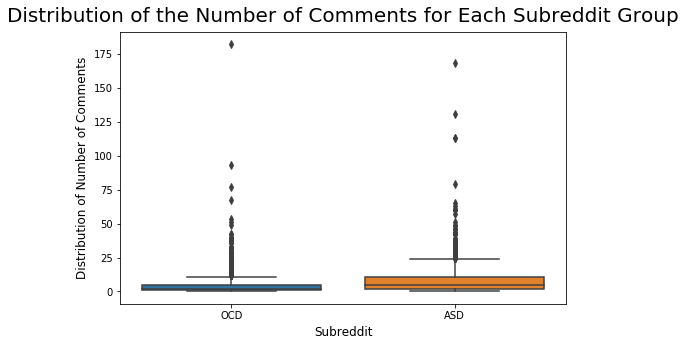

In [28]:
# Visualizing the distribution of number of comments for each subreddits 
plt.figure(figsize=(8,5)) 
plt.title("Distribution of the Number of Comments for Each Subreddit Group", fontsize = 20, pad = 10)
sns.boxplot(x = data['subreddit'], y = data['num_comments'])
plt.xlabel("Subreddit", fontsize = 12, labelpad = 5)
plt.ylabel("Distribution of Number of Comments", fontsize = 12, labelpad = 5)
plt.xticks(ticks=[0, 1], labels=['OCD', 'ASD']);

**Interpretation:** There seems to be a high number of outliers in the number of comments for both the OCD and ASD groups.   
However, there is no evidence to prove that those values are not valid data. As a result, we will no remove them.

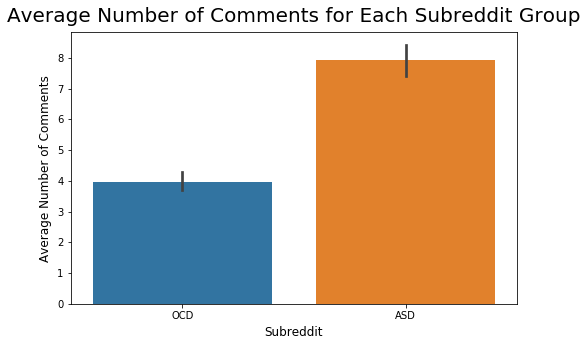

In [29]:
# Visualizing the average number of comments for each subreddits 
plt.figure(figsize=(8,5)) 
plt.title("Average Number of Comments for Each Subreddit Group", fontsize = 20, pad = 10)
sns.barplot(x=data['subreddit'], y=data['num_comments'])
plt.xlabel("Subreddit", fontsize = 12, labelpad = 5)
plt.ylabel("Average Number of Comments", fontsize = 12, labelpad = 5)
plt.xticks(ticks=[0, 1], labels=['OCD', 'ASD']);

**Interpretation:** On average, there is a higher number of comments posted in response to submissions on the autism subreddit compared to the OCD subreddit. 

### Score Analysis

In [30]:
data.groupby('subreddit')['score'].mean()

subreddit
0    1.016297
1    1.019964
Name: score, dtype: float64

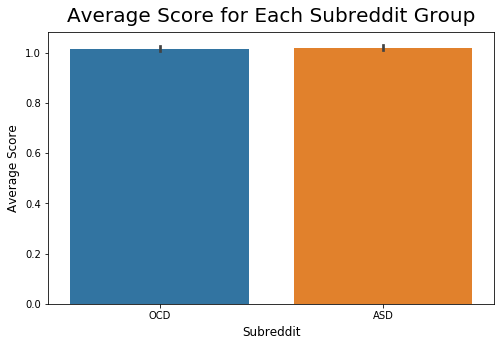

In [93]:
# Visualizing the average score for each subreddits 
plt.figure(figsize=(8,5)) 
plt.title("Average Score for Each Subreddit Group", fontsize = 20, pad = 10)
sns.barplot(x=data['subreddit'], y=data['score'])
plt.xlabel("Subreddit", fontsize = 12, labelpad = 5)
plt.ylabel("Average Score", fontsize = 12, labelpad = 5)
plt.xticks(ticks=[0, 1], labels=['OCD', 'ASD']);

**Interpretation:** The two groups have very similar mean scores 

### Timestamps Analysis

In [31]:
data.groupby('subreddit')['timestamp'].describe()

,count,unique,top,freq
subreddit,,,,
0,2209,34,2020-02-20,98
1,1653,50,2020-02-18,62


**Interpretation:**  
Highest number of submissions on the autism subreddit posted on Tuesday Feb. 18th 2020.  
Highest number of submissions on the OCD subreddit posted on Thursday Feb. 20th 2020. 

### Most Frequent Words Analysis

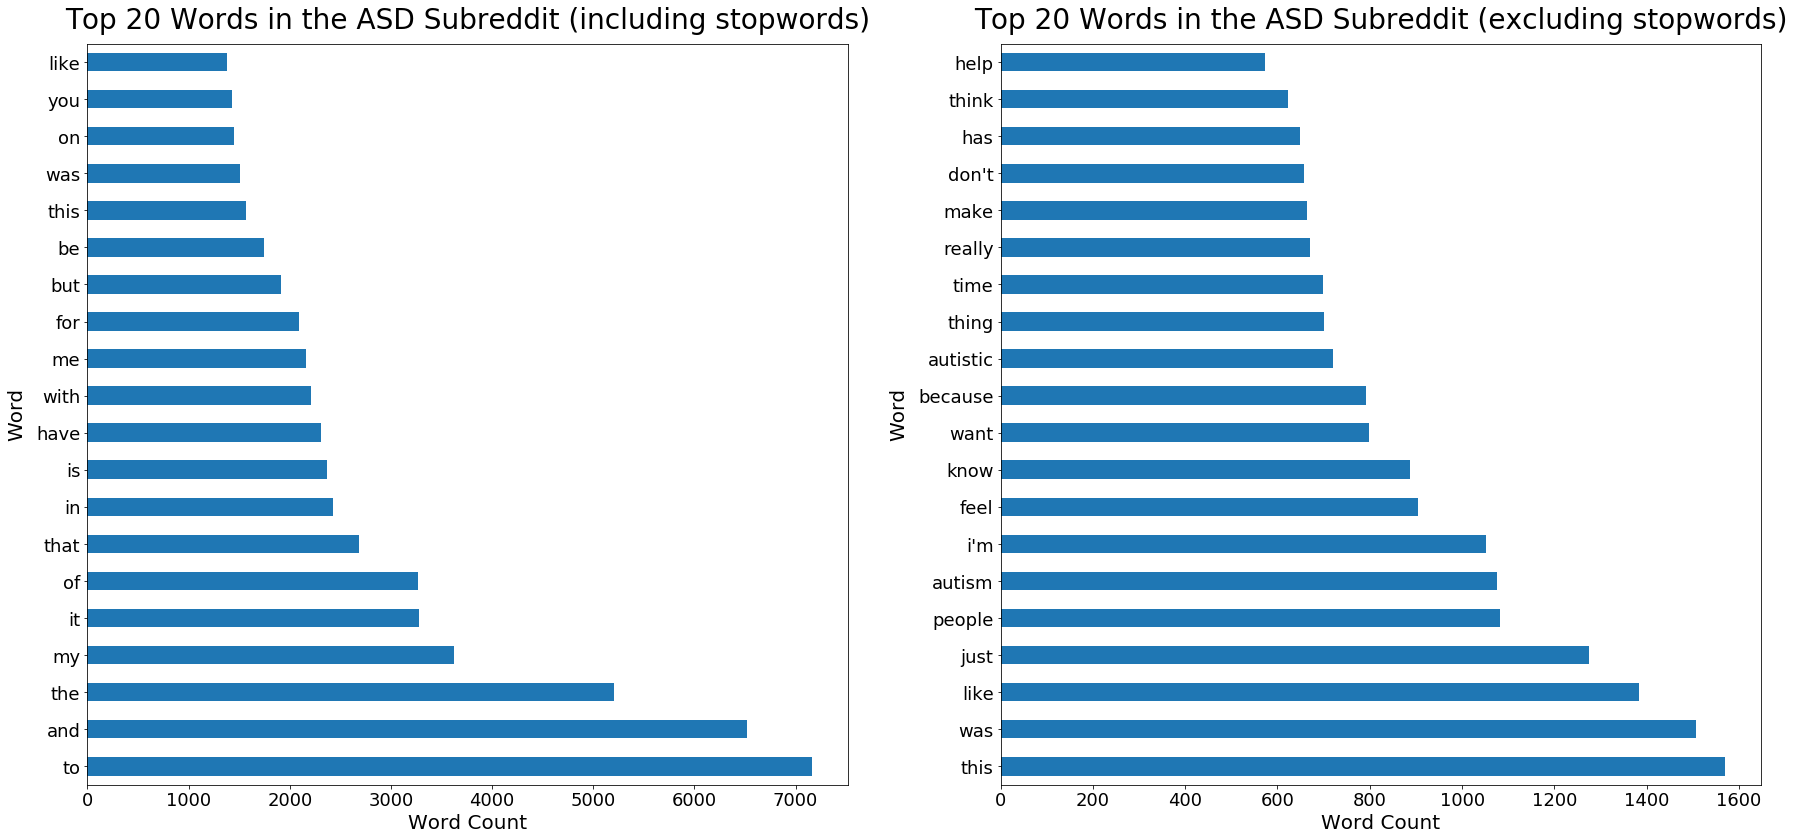

In [32]:
# Visualizing the 20 most frequent words in the ASD subreddit with and without stopwords

#Creating with matrix with the 20 most common ASD words including stopwords
cvec = CountVectorizer(max_features = 20)
test_text = cvec.fit_transform(data[data['subreddit']==1]['cleaned_text'])
test_df_asd = pd.DataFrame(test_text.toarray(), columns=cvec.get_feature_names())

#Creating with matrix with the 20 most common ASD words excluding stopwords
cvec = CountVectorizer(max_features = 20, stop_words='english')
test_text = cvec.fit_transform(data[data['subreddit']==1]['cleaned_text'])
test_df_asd_no_stop = pd.DataFrame(test_text.toarray(), columns=cvec.get_feature_names())

#Visualizing the 20 most common ASD words including stopwords 
plt.figure(figsize=(30,30))
plt.subplot(2,2,1)
test_df_asd.sum().sort_values(ascending=False).plot(kind='barh')
plt.title('Top 20 Words in the ASD Subreddit (including stopwords)', size=28, pad=15)
plt.xlabel('Word Count', size=20)
plt.tick_params(labelsize = 18)
plt.ylabel('Word', size=20, labelpad=10)
plt.yticks(np.arange(20), 
           ['to', 'and', 'the', 'my', 'it', 'of', 'that', 'in', 'is', 'have', 'with', 'me', 
           'for', 'but', 'be', 'this', 'was', 'on', 'you', 'like']);

#Visualizing the 20 most common ASD words excluding stopwords 
plt.subplot(2,2,2)
test_df_asd_no_stop.sum().sort_values(ascending=False).plot(kind='barh')
plt.title('Top 20 Words in the ASD Subreddit (excluding stopwords)', size=28, pad=15)
plt.xlabel('Word Count', size=20)
plt.tick_params(labelsize = 18)
plt.ylabel('Word', size=20, labelpad=10)
plt.yticks(np.arange(20), 
           ['this', 'was', 'like', 'just', 'people', 'autism', "i'm", 'feel', 'know', 'want',
           'because', 'autistic', 'thing','time', 'really', 'make', "don't", 'has', 'think', 'help']);

# Code for this visual adapted from code by Matthew Malone 

**Interpretation:** A majority of the 20 most frequent words in the ASD reddit are common stopwords. As a result, it may be a good idea to remove stopwords in our model. When we remove those, we are seeing a lot more words related to autism (such as autistic and autism) appear as "top words"

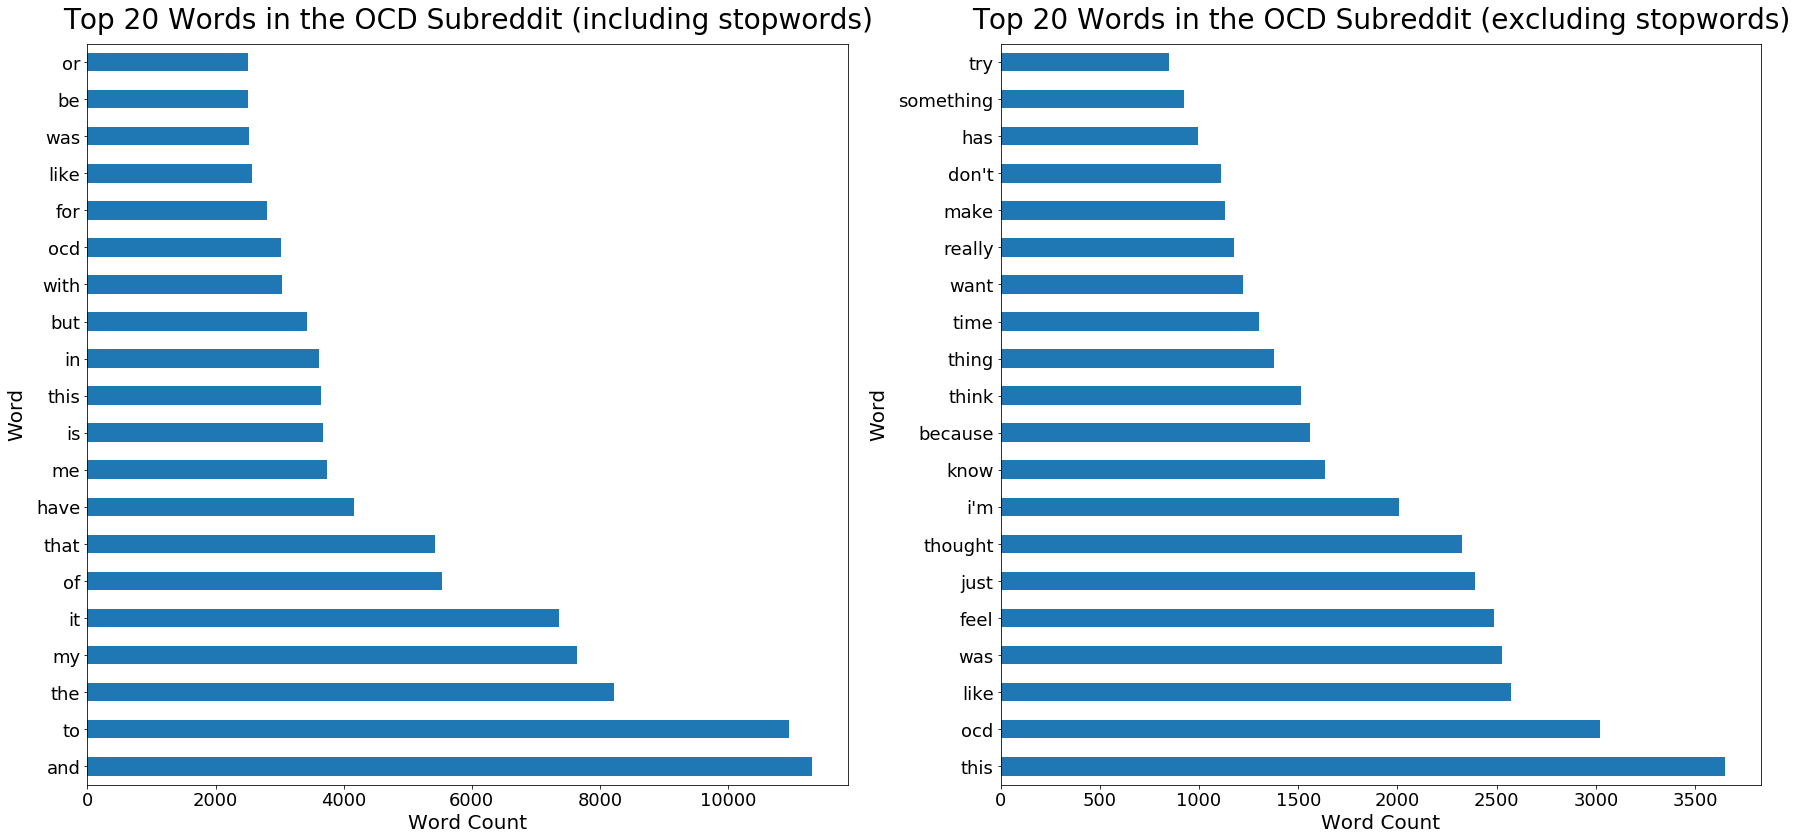

In [33]:
# Visualizing the 20 most frequent words in the OCD subreddit with and without stopwords

#Creating with matrix with the 20 most common OCD words including stopwords
cvec = CountVectorizer(max_features = 20)
test_text = cvec.fit_transform(data[data['subreddit']==0]['cleaned_text'])
test_df_ocd = pd.DataFrame(test_text.toarray(), columns=cvec.get_feature_names())

#Creating with matrix with the 20 most common OCD words excluding stopwords
cvec = CountVectorizer(max_features = 20, stop_words='english')
test_text = cvec.fit_transform(data[data['subreddit']==0]['cleaned_text'])
test_df_ocd_no_stop = pd.DataFrame(test_text.toarray(), columns=cvec.get_feature_names())

#Visualizing the 20 most common OCD words including stopwords 
plt.figure(figsize=(30,30))
plt.subplot(2,2,1)
test_df_ocd.sum().sort_values(ascending=False).plot(kind='barh');
plt.title('Top 20 Words in the OCD Subreddit (including stopwords)', size=28, pad=15)
plt.xlabel('Word Count', size=20)
plt.tick_params(labelsize = 18)
plt.ylabel('Word', size=20, labelpad=10)
plt.yticks(np.arange(20), 
           ['and', 'to', 'the', 'my', 'it', 'of', 'that', 'have', 'me', 'is', 'this', 'in', 
           'but', 'with', 'ocd', 'for', 'like', 'was', 'be', 'or']);


#Visualizing the 20 most common OCD words excluding stopwords 
plt.subplot(2,2,2)
test_df_ocd_no_stop.sum().sort_values(ascending=False).plot(kind='barh')
plt.title('Top 20 Words in the OCD Subreddit (excluding stopwords)', size=28, pad=15)
plt.xlabel('Word Count', size=20)
plt.tick_params(labelsize = 18)
plt.ylabel('Word', size=20, labelpad=10)
plt.yticks(np.arange(20), 
           ['this', 'ocd', 'like', 'was', 'feel', 'just', 'thought', "i'm", 'know', 'because', 
           'think', 'thing', 'time', 'want', 'really', 'make', "don't", 'has', 'something', 'try']);

# Original code for this visual brought to you by Matthew Malone 

**Interpretation:** A majority of the 20 most frequent words in the ASD reddit are common english stopwords. As a result, it may be a good idea to remove stopwords in our model. Indeed, when removing those stopwords more disease specific words (such as thought) emerge as "top words".

In [34]:
# Creating lists for 20 most common OCD and ASD words 
top_ocd = list(test_df_ocd_no_stop.columns)
top_asd = list(test_df_asd_no_stop.columns)

# Creating a list of words that are part on the 20 most common words in both subreddits 
all_words = set(top_ocd + top_asd)
top_ocd_and_asd = [w for w in all_words if (w in top_ocd) and (w in top_asd)]

In [35]:
# Creating a function labeling a word as either part of the top ASD words, top OCD words, or both
def subreddit(row):
    if row in top_ocd_and_asd: 
        subreddit = 'both'
    elif row in top_asd:
        subreddit = 'ASD'
    else: 
        subreddit = 'OCD'
    return subreddit 

In [36]:
# Creating a dataframe of the 20 most common words in our dataset (not including english stopwords)
cvec = CountVectorizer(max_features = 20, stop_words='english')
test_all_text = cvec.fit_transform(data['cleaned_text'])
test_all_text_df = pd.DataFrame(test_all_text.toarray(), columns=cvec.get_feature_names())

new_df = test_all_text_df.T
new_df['total'] = list(test_all_text_df.sum())

new_df_2 = new_df[['total']]
new_df_2 = new_df_2.sort_values(by='total')
new_df_2.loc[new_df_2.index, 'subreddit'] = [subreddit(word) for word in new_df_2.index]
# code adapted from https://stackoverflow.com/questions/21702342/creating-a-new-column-based-on-if-elif-else-condition

In [37]:
new_df_2.head()

,total,subreddit
help,1400,ASD
ha,1641,both
dont,1767,both
make,1796,both
peopl,1819,ASD


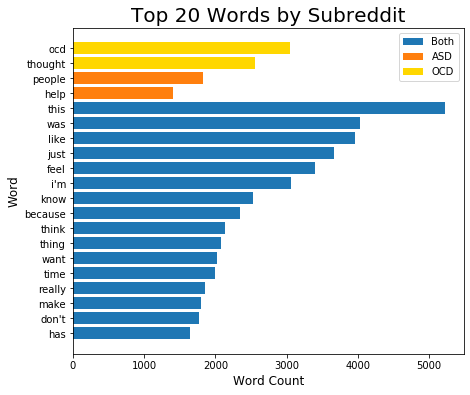

In [38]:
# Visualizing the 20 most frequent words in our dataset (not including english stopwords)
plt.figure(figsize = (7,6))
plt.barh(width=new_df_2[new_df_2['subreddit']=='both']['total'], y=new_df_2[new_df_2['subreddit']=='both'].index)
plt.barh(width=new_df_2[new_df_2['subreddit']=='ASD']['total'], y=new_df_2[new_df_2['subreddit']=='ASD'].index)
plt.barh(width=new_df_2[new_df_2['subreddit']=='OCD']['total'], y=new_df_2[new_df_2['subreddit']=='OCD'].index, color='gold')
plt.title('Top 20 Words by Subreddit', size=20)
plt.xlabel('Word Count', size=12)
plt.ylabel('Word', size=12)
plt.yticks(np.arange(20), 
           ['has', "don't", 'make', 'really', 'time', 'want', 'thing', 'think', 'because', 'know', "i'm", 'feel', 
           'just', 'like', 'was', 'this', 'help', 'people', 'thought', 'ocd'])
plt.legend(['Both', 'ASD', 'OCD']);

**Interpretation:** Most of the 20 most frequent words in our dataset are common in both the OCD and ASD subreddits. This makes sense considering that the two disorders share symptoms and that users are sharing similar type of information on both subreddits. However, those words are not very helpful to differentiate between the two populations. As a results, words that are common in both ASD and OCD subreddits should be included in a custom stopwords list.  
Out of the most frequent 20 words, only 2 words are specific to ASD: "people" and "help" and only 2 words are specific to OCD: "ocd" and "thought". Those words make sense considering that autism is a disorder characterized by more social  deficits while OCD is more defined by intrusive thoughts.   
Note: While we are only showing the most frequent 20 words here, the same analysis was done with the most frequent 50 words in order to identify more potential stopwords. 

### Creating Custom Stopwords List 

In [40]:
# Creating matrices for the most common 50 words in the ASD and OCD subreddits 
cvec = CountVectorizer(max_features = 50, stop_words='english')

test_text = cvec.fit_transform(data[data['subreddit']==1]['cleaned_text'])
test_auti = pd.DataFrame(test_text.toarray(), columns=cvec.get_feature_names())

test_text2 = cvec.fit_transform(data[data['subreddit']==0]['cleaned_text'])
test_ocid = pd.DataFrame(test_text2.toarray(), columns=cvec.get_feature_names())

In [41]:
# Create custom list of stopwords 
additional_words = [word for word in test_auti.columns if word in test_ocid.columns]
my_stopwords = frozenset(additional_words+ stopwords.words('english'))

Given the information gathered during EDA, we believe the data available will allow us to successfully answer our problem statement. 

## Model Preparation

In [42]:
# Setting up our variables and train-test split
X = data['cleaned_text']
y = data['subreddit']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

## Modeling

### Baseline Model

In [43]:
# Checking baseline model score 
dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train, y_train)
print(f'Baseline Training Score: {dummy.score(X_train, y_train)}')
print(f'Baseline Testing Score: {dummy.score(X_test, y_test)}')

Baseline Training Score: 0.5718232044198895
Baseline Testing Score: 0.572463768115942


**Interpretation:** If we always predicted the majority class (OCD), our "model" would have a 57% accuracy. 

### Logistic Regression

#### Logistic Regression + CountVectorizer 

In [44]:
#Creating pipeline for Log Reg CountVectorizer: 

# Define Pipeline
pipe = Pipeline(steps = [
    ('vectorizer', CountVectorizer()), 
    ('lg', LogisticRegression(solver='liblinear')) 
])

# Construct Grid Parameters
hyperparams = {
    'vectorizer__ngram_range':[(1,2)], 
    'vectorizer__stop_words': [my_stopwords],
    'vectorizer__max_features': [2000],
    'lg__max_iter': [200]
}

# Perform Grid Search
gs = GridSearchCV(pipe,
                 param_grid=hyperparams,
                 cv = 3,
                 scoring = 'accuracy')
lg_cvec = gs.fit(X_train, y_train)

# Scoring 
print(f'Best Training Accuracy: {lg_cvec.score(X_train, y_train)}')
print(f'Best Testing Accuracy: {lg_cvec.score(X_test, y_test)}')
print(f'Cross-val-score: {cross_val_score(lg_cvec.best_estimator_, X, y).mean()}')

Best Training Accuracy: 0.9917127071823204
Best Testing Accuracy: 0.9213250517598344
Cross-val-score: 0.92284015577556


**Interpretation:** This model is highly overfit with a training score of 99.2% much higher than our testing score of **92.1% accuracy**. The cross-val-score being very close to the testing score indicates that our testing set is a valid representation of the data. Although our model is overfit, the high testing score indicates that it still provides high predictive power.   
Note: More parameters than the ones appearing above were investigated during our search for the best model. However, in order to decrease runtime, only the parametters giving us the best test score (identified using `.best_params_`) were included in this notebook. 

#### Logistic Regression + TFIDFVectorizer

In [46]:
#Creating pipeline for Log Reg TFIDFVectorizer: 

# Define Pipeline
pipe = Pipeline(steps = [
    ('vectorizer', TfidfVectorizer()), 
    ('lg', LogisticRegression(solver='liblinear')) 
])

# Construct Grid Parameters
hyperparams = {
    'vectorizer__ngram_range':[(1,1)], 
    'vectorizer__stop_words': [my_stopwords],
    'vectorizer__max_features': [3000],
    'lg__max_iter': [50], 
    'lg__penalty': ['l2'],
    'lg__C': [3]
}

# Perform Grid Search
gs = GridSearchCV(pipe,
                 param_grid=hyperparams,
                 cv = 3,
                 scoring = 'accuracy')
lg_tfidf = gs.fit(X_train, y_train)

# Scoring 
print(f'Best Training Accuracy: {lg_tfidf.score(X_train, y_train)}')
print(f'Best Testing Accuracy: {lg_tfidf.score(X_test, y_test)}')
print(f'Cross-val-score: {cross_val_score(lg_tfidf.best_estimator_, X, y).mean()}')

Best Training Accuracy: 0.988950276243094
Best Testing Accuracy: 0.9337474120082816
Cross-val-score: 0.9259456126121899


**Interpretation:** This model is highly overfit with a training score of 98.9% much higher than our testing score of **93.4% accuracy**. The cross-val-score being close to the testing score indicates that our testing set is a valid representation of the data. Although our model is overfit, the high testing score indicates that it still provides high predictive power.   
Note: More parameters than the ones appearing above were investigated during our search for the best model. However, in order to decrease runtime, only the parametters giving us the best test score (identified using `.best_params_`) were included in this notebook. 

### kNN 

#### kNN + CountVectorizer

In [48]:
#Creating pipeline for kNN CountVectorizer: 

# Define Pipeline
pipe = Pipeline(steps = [
    ('vectorizer', CountVectorizer()),
    ('sc', MaxAbsScaler()),
    ('knn', KNeighborsClassifier())
])

# Construct Grid Parameters
hyperparams = {
    'vectorizer__ngram_range':[(1,2)], 
    'vectorizer__stop_words': [my_stopwords],
    'vectorizer__max_features': [500],
    'knn__n_neighbors': [10], 
    'knn__metric': ['minkowski']
}

# Perform Grid Search
gs = GridSearchCV(pipe,
                 param_grid=hyperparams,
                 cv = 3,
                 scoring = 'accuracy')
knn_cvec = gs.fit(X_train, y_train)

# Scoring 
print(f'Best Training Accuracy: {knn_cvec.score(X_train, y_train)}')
print(f'Best Testing Accuracy: {knn_cvec.score(X_test, y_test)}')
print(f'Cross-val-score: {cross_val_score(knn_cvec.best_estimator_, X, y).mean()}')

Best Training Accuracy: 0.7935082872928176
Best Testing Accuracy: 0.7298136645962733
Cross-val-score: 0.7216577629718008


**Interpretation:** This model is overfit with a training score of 79.4% higher than our testing score of **73% accuracy**. The cross-val-score being close to the testing score indicates that our testing set is a valid representation of the data.   
Note: More parameters than the ones appearing above were investigated during our search for the best model. However, in order to decrease runtime, only the parametters giving us the best test score (identified using `.best_params_`) were included in this notebook. 

#### kNN + TFIDFVectorizer

In [50]:
#Creating pipeline for kNN TFIDFVectorizer: 

# Setting model specific train/test split
X_train_knn, X_test_knn, y_train_knn, y_test_knn = train_test_split(X, y, random_state=22, stratify=y)

# Define Pipeline
pipe = Pipeline(steps = [
    ('vectorizer', TfidfVectorizer()), 
    ('sc', MaxAbsScaler()),
    ('knn', KNeighborsClassifier()) 
])

# Construct Grid Parameters
hyperparams = {
    'vectorizer__ngram_range':[(1,2)], 
    'vectorizer__stop_words': [None],
    'vectorizer__max_features': [2200],
    'knn__n_neighbors': [8], 
    'knn__metric': ['minkowski']
}

# Perform Grid Search
gs = GridSearchCV(pipe,
                 param_grid=hyperparams,
                 cv = 3,
                 scoring = 'accuracy')
knn_tfidf = gs.fit(X_train_knn, y_train_knn)

# Scoring 
print(f'Best Training Accuracy: {knn_tfidf.score(X_train_knn, y_train_knn)}')
print(f'Best Testing Accuracy: {knn_tfidf.score(X_test_knn, y_test_knn)}')
print(f'Cross-val-score: {cross_val_score(knn_tfidf.best_estimator_, X, y).mean()}')

Best Training Accuracy: 0.6056629834254144
Best Testing Accuracy: 0.5817805383022774
Cross-val-score: 0.5357251539992895


**Interpretation:** This model is slightly overfit with a training score of 60.6% slighy higher than our testing score of **58.2% accuracy**. This model is performing poorly with an accuracy barely above the baseline accuracy of 57%. The cross-val-score being somewhat far from the testing score indicates that our testing set may not be the best for this model. This discrepancy was much more important with the original train-test-split (using a random state of 42) which lead us to try a custom train-test-split for this model. This brought our test and cross-val scores closer together. However, they remain farther apart than we would like to see for an optimal model.     
Note: More parameters than the ones appearing above were investigated during our search for the best model. However, in order to decrease runtime, only the parametters giving us the best test score (identified using `.best_params_`) were included in this notebook. 

### Naive Bayes

#### Multinomial Naive Bayes + CountVectorizer

In [52]:
#Creating pipeline for Multinomial NB CountVectorizer: 

# Define Pipeline
pipe = Pipeline(steps = [
    ('vectorizer', CountVectorizer()), 
    ('mnb', MultinomialNB()) 
])

# Construct Grid Parameters
hyperparams = {
    'vectorizer__ngram_range':[(1,2)], 
    'vectorizer__stop_words': [my_stopwords],
    'vectorizer__max_features':  [2500], 
    'mnb__alpha': [0.3]
}

# Perform Grid Search
gs = GridSearchCV(pipe,
                 param_grid=hyperparams,
                 cv = 3,
                 scoring = 'accuracy')
mnb_cvec = gs.fit(X_train, y_train)

# Scoring 
print(f'Best Training Accuracy: {mnb_cvec.score(X_train, y_train)}')
print(f'Best Testing Accuracy: {mnb_cvec.score(X_test, y_test)}')
print(f'Cross-val-score: {cross_val_score(mnb_cvec.best_estimator_, X, y).mean()}')

Best Training Accuracy: 0.9437154696132597
Best Testing Accuracy: 0.9140786749482401
Cross-val-score: 0.916625555503422


**Interpretation:** This model is overfit with a training score of 94.4% higher than our testing score of **91.4% accuracy**. The cross-val-score being close to the testing score indicates that our testing set is a valid representation of the data. Although our model is overfit, the high testing score indicates that it still provides high predictive power.   
Note: More parameters than the ones appearing above were investigated during our search for the best model. However, in order to decrease runtime, only the parametters giving us the best test score (identified using `.best_params_`) were included in this notebook. 

#### Gaussian NB + TFIDFVectorizer

In [54]:
#Creating pipeline for Gaussian NB TFIDFVectorizer: 

# Define Pipeline
pipe = Pipeline(steps = [
    ('vectorizer', TfidfVectorizer()), 
    ('denser', FunctionTransformer(lambda x: x.todense(), accept_sparse=True)), 
    ('gnb', GaussianNB()) 
])

# Construct Grid Parameters
hyperparams = {
    'vectorizer__ngram_range':[(1,2)], 
    'vectorizer__stop_words': [None],
    'vectorizer__max_features': [2000],
}

# Perform Grid Search
gs = GridSearchCV(pipe,
                 param_grid=hyperparams,
                 cv = 3,
                 scoring = 'accuracy')
gnb_tfidf = gs.fit(X_train, y_train)

# Scoring 
print(f'Best Training Accuracy: {gnb_tfidf.score(X_train, y_train)}')
print(f'Best Testing Accuracy: {gnb_tfidf.score(X_test, y_test)}')
print(f'Cross-val-score: {cross_val_score(gnb_tfidf.best_estimator_, X, y).mean()}')

#Fix to sparse array error from https://stackoverflow.com/questions/28384680/scikit-learns-pipeline-a-sparse-matrix-was-passed-but-dense-data-is-required

Best Training Accuracy: 0.9578729281767956
Best Testing Accuracy: 0.9037267080745341
Cross-val-score: 0.9036758742266521


**Interpretation:** This model is highly overfit with a training score of 95.8% much higher than our testing score of **90.4% accuracy**. The cross-val-score being close to the testing score indicates that our testing set is a valid representation of the data. Although our model is overfit, the high testing score indicates that it still provides high predictive power.   
Note: More parameters than the ones appearing above were investigated during our search for the best model. However, in order to decrease runtime, only the parametters giving us the best test score (identified using `.best_params_`) were included in this notebook. 

### SVM

#### SVM + CountVectorizer

In [56]:
#Creating pipeline for SVC CountVectorizer: 

# Define Pipeline
pipe = Pipeline(steps = [
    ('vectorizer', CountVectorizer()),
    ('sc', MaxAbsScaler()),
    ('svc', SVC())
])

# Construct Grid Parameters
hyperparams = {
    'vectorizer__ngram_range':[(1,1)], 
    'vectorizer__stop_words': [my_stopwords],
    'vectorizer__max_features': [300],
    'svc__degree': [0.2], 
    'svc__C': [10], 
    'svc__kernel': ['rbf']
   
}

# Perform Grid Search
gs = GridSearchCV(pipe,
                 param_grid=hyperparams,
                 cv = 3,
                 scoring = 'accuracy')
svc_cvec = gs.fit(X_train, y_train)

# Scoring 
print(f'Best Training Accuracy: {svc_cvec.score(X_train, y_train)}')
print(f'Best Testing Accuracy: {svc_cvec.score(X_test, y_test)}')
print(f'Cross-val-score: {cross_val_score(svc_cvec.best_estimator_, X, y).mean()}')

Best Training Accuracy: 0.9772099447513812
Best Testing Accuracy: 0.8913043478260869
Cross-val-score: 0.8788147919752797


**Interpretation:** This model is highly overfit with a training score of 97.7% much higher than our testing score of **89.1% accuracy**. The cross-val-score being close to the testing score indicates that our testing set is a valid representation of the data. Although our model is overfit, the high testing score indicates that it still provides  predictive power.   
Note: More parameters than the ones appearing above were investigated during our search for the best model. However, in order to decrease runtime, only the parametters giving us the best test score (identified using `.best_params_`) were included in this notebook. 

#### SVM + TFIDFVectorizer 

In [58]:
#Creating pipeline for SVC TFIDFVectorizer: 

# Define Pipeline
pipe = Pipeline(steps = [
    ('vectorizer', TfidfVectorizer()),
    ('sc', MaxAbsScaler()),
    ('svc', SVC())
])

# Construct Grid Parameters
hyperparams = {
    'vectorizer__ngram_range':[(1,2)], 
    'vectorizer__stop_words': [my_stopwords],
    'vectorizer__max_features': [350],
    'svc__degree': [0.2], 
    'svc__C': [8],
    'svc__kernel': ['rbf']
   
}

# Perform Grid Search
gs = GridSearchCV(pipe,
                 param_grid=hyperparams,
                 cv = 3,
                 scoring = 'accuracy')
svc_tfidf = gs.fit(X_train, y_train)

# Scoring 
print(f'Best Training Accuracy: {svc_tfidf.score(X_train, y_train)}')
print(f'Best Testing Accuracy: {svc_tfidf.score(X_test, y_test)}')
print(f'Cross-val-score: {cross_val_score(svc_tfidf.best_estimator_, X, y).mean()}')

Best Training Accuracy: 0.994475138121547
Best Testing Accuracy: 0.8995859213250518
Cross-val-score: 0.9041936737963254


**Interpretation:** This model is highly overfit with a training score of 99.4% much higher than our testing score of **90% accuracy**. The cross-val-score being close to the testing score indicates that our testing set is a valid representation of the data. Although our model is overfit, the high testing score indicates that it still provides  predictive power.   
Note: More parameters than the ones appearing above were investigated during our search for the best model. However, in order to decrease runtime, only the parametters giving us the best test score (identified using `.best_params_`) were included in this notebook. 

## Model Selection

As stated in our problem statement, we are looking for the model providing the highest accuracy. More specifically, we are looking for the model with the highest testing accuracy. Indeed, since our model will be used to classify new posts, we need high predictive power on data our model has not been fitted on (never seen before).  

<img src="../assets/table.png" width="1000px">


The model providing with highest test accurary score is the **Logistic Regression model with TFIDF Vectorizer**. This model is overfit, however it still provides high predictive power which is what we care about given our problem statement. Although our main goal is predictability, having a model that is also interpretable (the way logistic regresssion is) is a very valuable bonus. 

## Model Evaluation

In [92]:
# Looking at best model parameters 
lg_tfidf.best_params_

{'lg__C': 3,
 'lg__max_iter': 50,
 'lg__penalty': 'l2',
 'vectorizer__max_features': 3000,
 'vectorizer__ngram_range': (1, 1),
 'vectorizer__stop_words': frozenset({'a',
            'about',
            'above',
            'after',
            'again',
            'against',
            'ain',
            'all',
            'alway',
            'am',
            'an',
            'and',
            'ani',
            'any',
            'anyon',
            'are',
            'aren',
            "aren't",
            'as',
            'at',
            'be',
            'becaus',
            'because',
            'been',
            'before',
            'being',
            'below',
            'between',
            'both',
            'but',
            'by',
            'can',
            'couldn',
            "couldn't",
            'd',
            'day',
            'did',
            'didn',
            "didn't",
            'do',
            'does',
            'doesn',
     

**Interpretation:** The best model used the 3000 most common words and our custom stopwords. 

### Confusion Matrix

In [61]:
# Making predictions
predictions = lg_tfidf.predict(X_test)

# Creating confusion matrix 
cm = confusion_matrix(y_test, predictions)
cm

array([[516,  37],
       [ 27, 386]])

In [62]:
# Visualizing our confusion matrix  
pd.DataFrame(cm, index=['Actually OCD', 'Actually ASD'],
                 columns=['Predicted OCD', 'Predicted ASD'])

,Predicted OCD,Predicted ASD
Actually OCD,516,37
Actually ASD,27,386


In [63]:
# Calculating Sensitivity: 
sensitivity = 386/(386+27)
print(f'Our Sensitivity is {np.round(sensitivity*100)}%')

# Calculating Specificity:
specificity = 516/(516+37)
print(f'Our Specificity is {np.round(specificity*100)}%')

# Calculating Precision: 
precision = 386/(386+37)
print(f'Our Precision is {np.round(precision*100)}%')


Our Sensitivity is 93.0%
Our Specificity is 93.0%
Our Precision is 91.0%


**Interpretation:**   
We are correctly classifying 516 out of the 553 OCD posts, and 386 out of the 413 ASD posts.  
We have a True Negative Rate (specificity) of 93% and a True Positive Rate (sensitivity) of 93%.  
Our Precision (how much we can trust a positive prediction) is 91%.   
Looking at our confusion matrix, we see that there are 37 posts that we predicted to be part of the ASD subreddit that were in fact part of the OCD subreddit. This means that in 3.8% of cases, we would be spending advertising money on the wrong user.  
In addition, there are 27 posts that our model predicted to be written by someone from the OCD community who was actually part of the ASD community. This means that in 2.8% of cases, we would be missing out on potential customers. 

### Understanding Misclassifications

In [64]:
# Creating a dataframe to compare our predictions to the actual subreddit
analysis = pd.DataFrame(y_test)
analysis['prediction'] = predictions
analysis['cleaned_text']= X_test
analysis.head()

,subreddit,prediction,cleaned_text
2018,0,0,someon told me what happen to you is becaus yo...
1495,0,0,share your ocd stori ocd mind trick what reali...
3225,1,1,therapi or counsel for adult in west of scotla...
3647,1,1,i am year old and look to get a formal diagnos...
2578,1,1,i did it im do realli well


In [65]:
# Looking at the first 5 misclassified posts 
analysis[analysis['subreddit'] != analysis['prediction']].head()

,subreddit,prediction,cleaned_text
3480,1,0,excess worri my littl sister is struggl with w...
2144,0,1,anyon buy sheryl paul s book have they help
1154,0,1,guilt and embarrass after read posit remark ab...
2303,1,0,doe anyon els doe anyon els get a huge fear of...
2627,1,0,my draw see that everybodi now post their artw...


Let's look at those first 5 misclassified posts and try to understand why they were misclassified.

In [85]:
# Printing the 1st misclassified post 
print(data.loc[3480, 'text'])

Excessive worrying My little sister (13) is struggling with worrying about everything and it’s starting to affect her school and sleep schedule. She worries about things like choking by having food stuck in her throat, getting sick (even a simple sore throat), frost bite, anything she deems disturbing like learning about history in social studies. We’ve spent a lot of time sitting down with her and talking to her about these thing like showing her a diagram of a throat so she sees how it works and that she won’t choke on her foods. We explain everything to her and she says she’s good and not worried, but a couple days later she’s back to worrying. If she stops one worrying about one thing, another one starts. It’s affecting her school performance and sleep so we’re desperate about trying anything that might work. She doesn’t sleep (stays up or gets up frequently) and says it’s because of her worry. If any of you have experienced anything like this, please let me know what has worked fo

**Interpretation:** This post, although on the ASD subreddit focusses mostly on anxiety which is a bigger problem for individuals with OCD. This is most likely why it was misclassified as an OCD post. 

In [82]:
# Printing the 2nd misclassified post 
print(data.loc[2144, 'text'])

Anyone buy Sheryl Paul’s books? Have they helped? 


**Interpretation:** The word "help" is more common in ASD posts, which is most likely why this post was misclassified as a ASD post. Our model would not be able to detect that Sheryl Paul's book is a book about anxiety [[source]](https://www.amazon.com/gp/product/B07FDQVKZ9/ref=dbs_a_def_rwt_hsch_vapi_tkin_p1_i0) (topic more common for individuals with OCD). 

In [81]:
# Printing the 3rd misclassified post 
print(data.loc[1154, 'text'])

Guilt and embarrassment after reading positive remarks about myself? I'm an undergrad senior, aspiring to go to grad school, and I applied to my first program recently. Received letters of recommendation from two faculty members  who have known me for less than a year (I worked in their respective labs) and got really good recommendations from them. After reading those letters, I am feeling extremely guilty and, frankly, embarrassed of myself (does this make sense?) I'm a very quiet person, not someone who is very communicative, sharp, or remarkably intelligent. My profs. are genuinely nice people, and I just feel like they're exaggerating (sure, there is always some exaggeration in LoRs but I genuinely don't think I deserve what is written; feels like they're talking about someone I am not). I don't know why but I'm feeling really ashamed of myself. All through my schooling, I was never the star student or the big-time achiever, and so the fact that this is happening is making me feel

**Interpretation:** This post mentions school which is usually a topic more discussed in the ASD subreddit (as individuals with ASD often struggle in school due to socialization issues). In addition, the user struggles with "shame" and "guilt" rather than more common OCD emotions such as "anxiety". This is most likely the reason why this post was misclassified as an ASD post. 

In [86]:
# Printing the 4th misclassified post 
print(data.loc[2303, "text"])

Does anyone else... Does anyone else get a huge fear of losing their current special interests? I love my special interests and I get so scared getting into new things in fear that I'll lose my SIs and replace them with new ones. 

And it happens, and it's happened, but it still scares me, I guess. It's weird. Does anyone know how to work around that and try to stop my fear?


**Interpretation:** This post discusses special interests, which are definitely an autism specific topic. Not picking this up is a weakness of our model and potential area for improvement. The post discusses fears which is something more often associated with OCD and could explain why the post was misclassified as an OCD post.

In [87]:
# Printing the 5th misclassified post 
print(data.loc[2027, 'text'])

How do you deal with superstitious intrusive thoughts? Magical thinking is annoying. I redo and undo things when I get the thought of someone I don't like pop into my head when I'm doing something because I fear something bad will happen. Please advice how I can stop myself from doing that compulsion? I get scared because..what if..just in case..how do I become strong and get rid of this? This is seriously taking control of my life.


**Interpretations:** Although this text was posted on the ASD reddit, the user discusses issues that describe OCD symptoms (mentioning intrusive thoughts and compulsions). This explains why the post was misclassified as an OCD post. As OCD can be a comorbid disorder to ASD, it is very possible that this user has both ASD and OCD given his post.  

### Coefficient Interpretation

In [73]:
# Creating a dataframe showing each word and its associated coefficient 
coefficients = pd.DataFrame(lg_tfidf.best_estimator_.steps[1][1].coef_[0], 
                           lg_tfidf.best_estimator_.steps[0][1].get_feature_names())
coefficients.rename(columns = {0: 'coef'}, inplace=True)
coefficients.head()

,coef
aba,0.783497
abandon,-0.197592
abil,0.829201
abilifi,-0.217594
abl,-0.209966


In [74]:
# Looking at the ten words with the highest coefficients 
coefficients['coef'].sort_values(ascending=False)[:10]

autism      9.387502
autist      6.774294
spectrum    3.657359
asd         3.270314
social      2.845516
meltdown    2.722922
sensori     2.719061
stim        2.627050
son         2.474558
special     2.446957
Name: coef, dtype: float64

**Interpretation:** Looking at the 10 words with the strongest positive coefficients, we see words that are specific to autism. Some are obvious (such as autism, autistic, spectrum and asd), others require more subject knowledge (such as stim). Indeed, "stims" refer to "self-stimulating behaviors" which are repetitive behaviors individuals with autism do to deal with the sensory overload they feel and sooth themselves. As autism is a disorder defined by social difficulties and sensory hyper or hypo-sensitivity, it makes sense for words like "stim" and "social" to be particularly helpful in classifying a post as being part of the ASD subreddit. 

In [75]:
# Looking at the ten words with the lowest coefficients 
coefficients['coef'].sort_values()[:10]

ocd       -15.472531
thought    -7.047279
obsess     -5.938760
compuls    -5.629279
intrus     -4.301791
fear       -3.385977
wash       -3.053326
trigger    -2.932675
bad        -2.824200
mind       -2.617679
Name: coef, dtype: float64

**Interpretation:** Looking at the 10 words with the strongest negative coefficients, we see words that are specific to OCD. Some are obvious (such as ocd, obsessive and compulsive), others require more subject knowledge (such as thought, intrusive, and fear). Indeed, OCD is defined by excessive thoughts (obsessions) that lead to repetitive behaviors (compulsions). Those thoughts are uncontrolled (often described as intrusive) and can be triggered by specific things. They can often be related to fears about germs and lead to a cleaning/hand washing compulsion. Those aspects of the disorder explain why the words above are helpful in classifying a post as "not an ASD post".  

In [76]:
# Filtering the ten words with the stongest coefficients 
top_coef = coefficients[(coefficients['coef'] > 3) | (coefficients['coef'] < -3.1)]
top_coef

,coef
asd,3.270314
autism,9.387502
autist,6.774294
compuls,-5.629279
fear,-3.385977
intrus,-4.301791
obsess,-5.938760
ocd,-15.472531
spectrum,3.657359
thought,-7.047279


In [77]:
# Adding the exponentiated coefficients 
top_coef['exp'] = np.exp(top_coef['coef'])
top_coef

/opt/anaconda3/envs/DSI/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,coef,exp
asd,3.270314,2.631961e+01
autism,9.387502,1.193824e+04
autist,6.774294,8.750613e+02
compuls,-5.629279,3.591165e-03
fear,-3.385977,3.384457e-02
intrus,-4.301791,1.354428e-02
obsess,-5.938760,2.635294e-03
ocd,-15.472531,1.907063e-07
spectrum,3.657359,3.875884e+01
thought,-7.047279,8.697720e-04


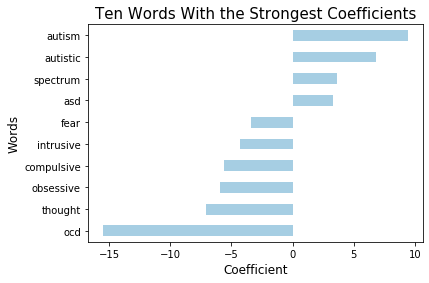

In [91]:
# Visualizing the 10 strongest coefficients 
top_coef.sort_values(by='coef')['coef'].plot(kind='barh', legend=None, cmap='Paired')
plt.title('Ten Words With the Strongest Coefficients', size=15)
plt.ylabel('Words', size=12)
plt.xlabel('Coefficient', size=12)
plt.yticks(np.arange(10), 
           ['ocd', 'thought', 'obsessive', 'compulsive', 'intrusive', 'fear', 'asd', 'spectrum', 'autistic', 'autism']);

**Interpretation:** Out of the ten words with the strongest coefficients, 4 are autism related words and 6 are OCD related words. The presence of the ASD related words make it more likely that the post would be part of the ASD reddit while the presence of the OCD related word make it less likely. (full interpretation of the 2 strongest coefficients below). 

In [79]:
(np.exp(-15.472531)-1)*100

-99.9999809293645

**Interpreting the 2 strongest coefficients:**   
- For a 1 unit increase in the use of the word “Autism”, the submission would be 11,938 times as likely to be posted in the ASD subreddit compared to the OCD subreddit (all else held constant).   
- For a 1 unit increase in the use of the word “OCD”, the submission would be 99.9% less likely to be posted in the ASD subreddit compared to the OCD subreddit (all else held constant). 

## Conclusion and Recommendations 

We identified a Logistic Regression model with TFIDF Vectorizer and custom stopwords as the model giving us the highest predictive power. This model classifies wether a post is part of the ASD subreddit or the OCD subreddit with 93% accuracy. As a result, this model would allow us to identify potential customers with autism based on their submissions on online resource blogs geared towards individuals with ASD and OCD.   
In 3.8% of cases we’re spending advertising money on the wrong users. In 2.8% of cases we’re missing out on potential customers. There is a tradeoff between those 2 types of errors.    
In the future, we can modify our model to minimize one type or the other based on recommendations from the marketing team. For instance, if the marketing budget is low, we may want to minimize the number of users we misclassify as having ASD when they actually have OCD (leading to unecessary advertising spendings). On the other hand, if we have a big marketing budget, we may want to minimize the number of users we misclassify as having OCD when they actually have ASD (making sure we are reaching out to every potential customers). 

## References

[Autism Reddit](https://www.reddit.com/r/autism/)  
[OCD Reddit](https://www.reddit.com/r/OCD/)  
[OCD resembles ASD](https://www.webmd.com/brain/autism/autism-similar-conditions)  
[Sheryl Paul Book](https://www.amazon.com/gp/product/B07FDQVKZ9/ref=dbs_a_def_rwt_hsch_vapi_tkin_p1_i0) 